In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline

from collections import OrderedDict
import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train_df = pd.read_csv('../input/train.csv', index_col='id')
test_df = pd.read_csv('../input/test.csv', index_col='id')

In [4]:
train_df.head()

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,-0.152,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,-0.732,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,1.173,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [5]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,0.191,...,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,1.350,...,-1.791,0.122,-0.669,-1.558,-0.244,2.583,-0.829,0.133,-2.746,0.341,-1.145,0.492,0.437,-0.628,0.271,2.639,0.481,-0.687,1.017,1.648,-1.272,-0.797,-0.870,-1.582,-1.987,-0.052,-0.194,0.539,-1.788,-0.433,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,0.999,...,-1.167,1.009,-0.180,-0.683,-1.383,1.020,0.268,-1.558,0.620,-0.489,-2.090,-0.977,1.672,-0.655,-0.801,-1.846,0.761,-0.846,0.181,0.962,-0.611,1.450,0.021,0.320,-0.951,-2.662,0.761,-0.665,-0.619,-0.645,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,0.818,...,-1.029,-0.340,0.052,2.122,-0.136,-1.799,1.450,1.866,-0.273,-0.237,-0.207,-0.196,-1.106,-1.560,-0.934,2.167,0.323,0.583,1.480,-0.685,-0.473,-1.066,-0.271,0.506,-0.753,1.048,-0.450,-0.300,-1.221,0.235,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,0.222,...,-0.486,-0.068,-0.534,-1.322,0.500,0.263,-0.745,0.578,-0.064,0.738,-0.280,0.745,-0.588,-0.429,-0.588,0.154,-1.187,1.681,-0.832,-0.437,-0.038,-1.096,-0.156,3.565,-0.428,-0.384,1.243,-0.966,1.525,0.458,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [6]:
print("number of training samples: ", train_df.shape[0])
print("number of testing samples: ", test_df.shape[0])

number of training samples:  250
number of testing samples:  19750


In [7]:
print("count of target values: ")
train_df.target.value_counts()

count of target values: 


1.0    160
0.0     90
Name: target, dtype: int64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


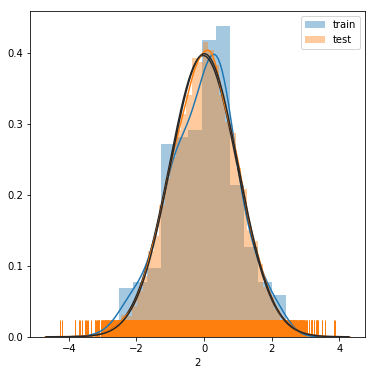

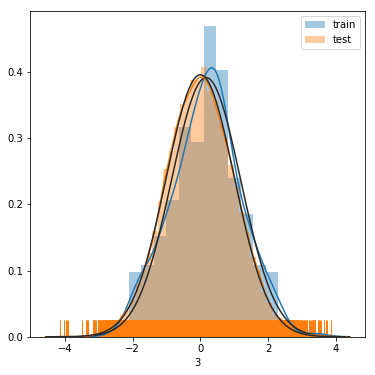

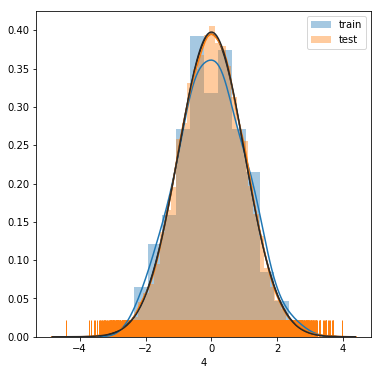

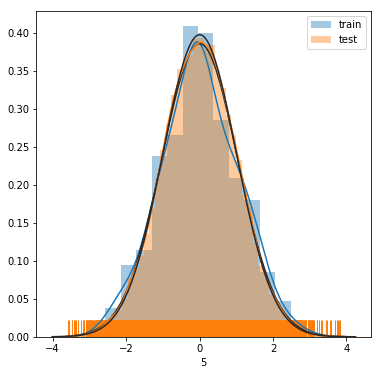

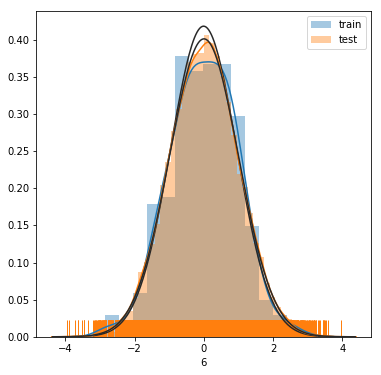

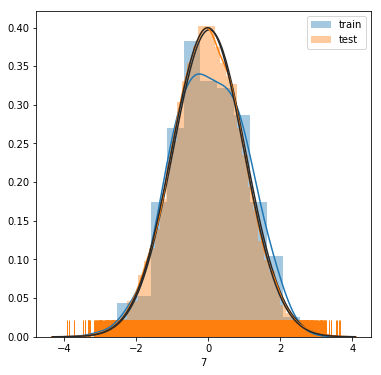

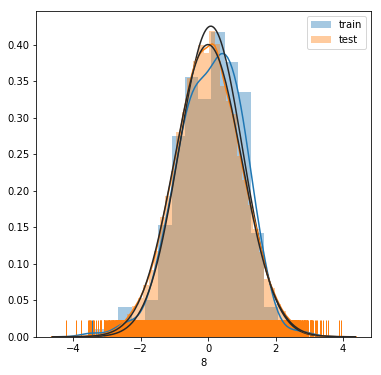

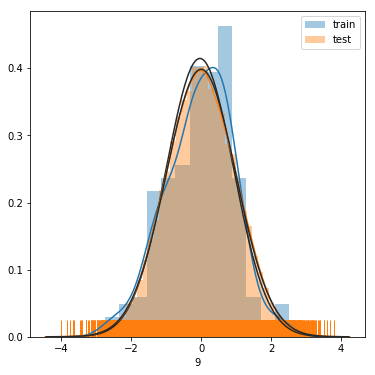

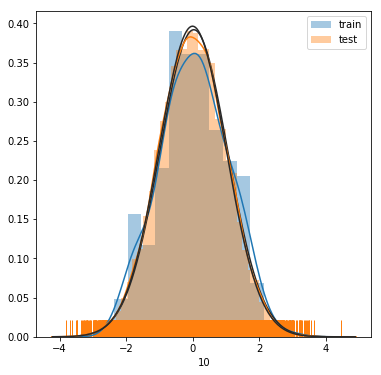

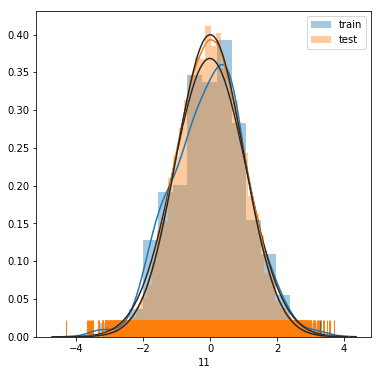

In [8]:
for ix in range(2,12): # (2, 302) for all features
    fig, ax = plt.subplots(figsize=(6,6))
    sns.distplot(train_df.iloc[:,ix], ax=ax, fit=norm, rug=True, label="train");
    sns.distplot(test_df.iloc[:,ix], ax=ax, fit=norm, rug=True, label="test");
    plt.legend()
    plt.show()

In [9]:
def bootstrap(data, target, n=5):
    """
    bootstrap samples for use testing model generalization
    """
    samples = []
    for i in range(n):
        ix = range(len(data))
        random_ixs = np.random.choice(ix, len(data), replace=True)
        new_data, new_target = data[random_ixs, :], target[random_ixs]
        samples.append((new_data, new_target))
    return samples

In [10]:
features = [col for col in train_df.columns if col.isdigit()]
target = 'target'

In [41]:
mean_train_auc_roc = []
mean_val_auc_roc = []

alpha_values = np.logspace(-3, -1, 20)
for a in alpha_values:
    # bootstrap_samples = bootstrap(X_train, y_train, 1000)
    # for sample in bootstrap_samples:
    #     X, y = sample

    X, y = train_df[features].values, train_df[target].values
    skf = StratifiedKFold(n_splits=5)

    # train_auc_roc = OrderedDict((label, []) for label, _ in clfs)
    # val_auc_roc = OrderedDict((label, []) for label, _ in clfs)
    train_auc_roc = []
    val_auc_roc = []

    for train_ix, val_ix in skf.split(X, y):
        X_train, y_train, X_val, y_val = X[train_ix], y[train_ix], X[val_ix], y[val_ix]
        lr = Lasso(alpha=a, normalize=False, max_iter=1000, precompute=True)
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_val_pred = lr.predict(X_val)
        train_auc_roc.append(roc_auc_score(y_train, y_train_pred))
        val_auc_roc.append(roc_auc_score(y_val, y_val_pred))
    
    mean_train_auc_roc.append(np.mean(train_auc_roc))
    mean_val_auc_roc.append(np.mean(val_auc_roc))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [42]:
max_alpha_ix = np.argmax(np.vstack((mean_train_auc_roc, mean_val_auc_roc)).mean(axis=0))
max_mean_cv_score = np.max(np.vstack((mean_train_auc_roc, mean_val_auc_roc)).mean(axis=0))
alpha = alpha_values[max_alpha_ix]
print("alpha: ", alpha, "max_mean, cv_score: ", max_mean_cv_score)

alpha:  0.029763514416313176 max_mean, cv_score:  0.9009982638888889


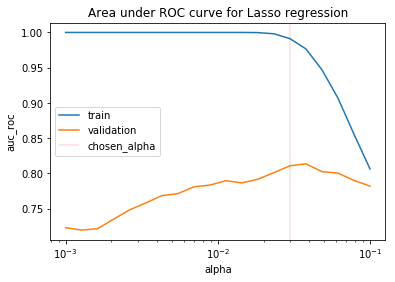

In [26]:
plt.figure(1)
plt.plot(alpha_values, mean_train_auc_roc, label='train')
plt.plot(alpha_values, mean_val_auc_roc, label='validation')
plt.axvline(x=alpha, lw=.2, color='red', label='chosen_alpha')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('auc_roc')
plt.title('Area under ROC curve for Lasso regression')
plt.legend(loc='best')
plt.show()

In [65]:
mean_train_auc_roc = []
mean_val_auc_roc = []

alpha_values = np.logspace(-3, -1, 20)
for a in alpha_values:
    # bootstrap_samples = bootstrap(X_train, y_train, 1000)
    # for sample in bootstrap_samples:
    #     X, y = sample

    X, y = train_df[features].values, train_df[target].values
    skf = StratifiedKFold(n_splits=5)

    # train_auc_roc = OrderedDict((label, []) for label, _ in clfs)
    # val_auc_roc = OrderedDict((label, []) for label, _ in clfs)
    train_auc_roc = []
    val_auc_roc = []

    for train_ix, val_ix in skf.split(X, y):
        X_train, y_train, X_val, y_val = X[train_ix], y[train_ix], X[val_ix], y[val_ix]
        lr = ElasticNet(alpha=a, l1_ratio=0.75, normalize=False, max_iter=1000, precompute=True)
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_val_pred = lr.predict(X_val)
        train_auc_roc.append(roc_auc_score(y_train, y_train_pred))
        val_auc_roc.append(roc_auc_score(y_val, y_val_pred))
    
    mean_train_auc_roc.append(np.mean(train_auc_roc))
    mean_val_auc_roc.append(np.mean(val_auc_roc))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [66]:
max_alpha_ix = np.argmax(np.vstack((mean_train_auc_roc, mean_val_auc_roc)).mean(axis=0))
max_mean_cv_score = np.max(np.vstack((mean_train_auc_roc, mean_val_auc_roc)).mean(axis=0))
alpha = alpha_values[max_alpha_ix]
print("alpha: ", alpha, "max_mean, cv_score: ", max_mean_cv_score)

alpha:  0.0379269019073225 max_mean, cv_score:  0.9021050347222223


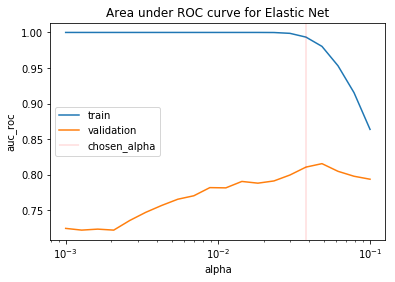

In [67]:
plt.figure(1)
plt.plot(alpha_values, mean_train_auc_roc, label='train')
plt.plot(alpha_values, mean_val_auc_roc, label='validation')
plt.axvline(x=alpha, lw=.2, color='red', label='chosen_alpha')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('auc_roc')
plt.title('Area under ROC curve for Elastic Net')
plt.legend(loc='best')
plt.show()

In [52]:
lr = ElasticNet(alpha=alpha, l1_ratio=0.75, normalize=False, max_iter=1000, precompute=True)
lr.fit(X_train, y_train)
test_predictions = lr.predict(test_df.values)

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(250,20000),
    'target': test_predictions
})
submission.to_csv("submission.csv", index=False)